In [26]:
# Import deep learning (tensorflow.keras) and relevant pyhthon libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA 
from lightgbm import LGBMClassifier
# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore')
from functools import reduce
from sklearn.preprocessing import LabelEncoder
# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D, Activation
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from typing import Tuple, List

In [27]:
def clean_application_data(df: pd.DataFrame) -> pd.DataFrame:
    """Cleans the application data by handling missing values and anomalies."""
    # Replace DAYS_EMPLOYED = 365243 by NaN
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Remove applications with XNA CODE_GENDER
    df = df[df['CODE_GENDER'] != 'XNA']
    
    return df

def engineer_application_features(df: pd.DataFrame) -> pd.DataFrame:
    """Performs feature engineering on application data."""
    # Feature engineering
    df['Days_employed_age'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['Credit_income_ratio'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['Annuity_income_ratio'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['Income_per_person'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['Credit_term'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # Handle division by zero or inf
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

def train_application() -> (pd.DataFrame, pd.DataFrame):
    """
    Reads, cleans, and performs feature engineering on application_train and application_test datasets.
    
    Returns:
    train, test: Two pandas DataFrames containing cleaned and engineered features from 
                 application_train and application_test tables.
    """
    print('Processing application_train and application_test tables')
    
    # Load train dataset
    train = pd.read_csv('application_train.csv')
    train = clean_application_data(train)
    train = engineer_application_features(train)
    
    # Load test dataset
    test = pd.read_csv('application_test.csv')
    test = engineer_application_features(test)
    
    return train, test


In [28]:

def preprocess_bureau_data(bureau):
    """Preprocesses the bureau data."""
    # Fill missing values
    cols_obj = bureau.select_dtypes(include='object').columns
    bureau[cols_obj] = bureau[cols_obj].fillna('Not_Applicable')
    cols_num = bureau.select_dtypes(exclude='object').columns
    bureau[cols_num] = bureau[cols_num].fillna(0)
    
    # One-hot encoding of categorical features
    bureau = pd.get_dummies(bureau, drop_first=True)
    return bureau

def reshape_bureau_data(bureau, sk_ids):
    """Reshapes bureau data into a structure suitable for CNN input."""
    group = bureau.groupby('SK_ID_CURR')
    reshaped_data = []
    n_features = bureau.shape[1] - 2  # Excluding SK_ID_CURR and SK_ID_BUREAU
    
    for sk in sk_ids:
        if sk in group.groups:
            group_data = group.get_group(sk)
            if group_data.shape[0] >= 5:
                group_data = group_data.iloc[:5]
            else:
                padding = pd.DataFrame(-99, index=range(5 - group_data.shape[0]), columns=group_data.columns)
                group_data = pd.concat([group_data, padding])
        else:
            group_data = pd.DataFrame(-99, index=range(5), columns=bureau.columns)
        
        group_data = group_data.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1)
        reshaped_data.append(group_data.values.flatten())
    
    reshaped_data = np.array(reshaped_data)
    reshaped_data = np.reshape(reshaped_data, (len(sk_ids), 5, n_features, 1))
    return reshaped_data

def create_cnn_model(input_shape):
    """Creates the CNN model."""
    model = Sequential()

    # 1st conv layer
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="same", input_shape=input_shape, data_format="channels_last"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd conv layer
    model.add(Conv2D(32, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(units=128))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Dense(units=100, name='feature_extract'))
    model.add(Activation("relu"))

    model.add(Dense(units=2, activation='sigmoid'))

    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

def bureau_CNN_features(train, test, nrows):
    """Extracts features using CNN from the bureau dataset."""
    print('Extracting features using Convolutional Neural Network (CNN)...')
    
    # Load and preprocess bureau data
    bureau = pd.read_csv('bureau.csv')
    bureau = preprocess_bureau_data(bureau)
    bureau = bureau.sort_values('DAYS_CREDIT', ascending=False)
    
    # Reshape bureau data for train set
    train_sk_ids = train['SK_ID_CURR'].values[:nrows]
    reshaped_bureau_train = reshape_bureau_data(bureau, train_sk_ids)
    
    # Encode target
    y_train = to_categorical(train['TARGET'].values[:nrows], 2)
    
    # Create and train CNN model
    cnn_model = create_cnn_model(input_shape=(reshaped_bureau_train.shape[1], reshaped_bureau_train.shape[2], 1))
    early_stops = EarlyStopping(patience=5, monitor='val_auc')
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    
    cnn_model.fit(reshaped_bureau_train, y_train, validation_split=0.05, callbacks=[early_stops, mc], batch_size=256, epochs=100, verbose=1)
    
    # Extract features
    feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('feature_extract').output)
    train_features = feature_extractor.predict(reshaped_bureau_train)
    
    # Create DataFrame for extracted features
    train_features_df = pd.DataFrame(train_features, columns=[f'bfeat_{i+1}' for i in range(train_features.shape[1])])
    train_features_df['SK_ID_CURR'] = train_sk_ids
    
    # Reshape bureau data for test set
    test_sk_ids = test['SK_ID_CURR'].values
    reshaped_bureau_test = reshape_bureau_data(bureau, test_sk_ids)
    test_features = feature_extractor.predict(reshaped_bureau_test)
    
    # Create DataFrame for test features
    test_features_df = pd.DataFrame(test_features, columns=[f'bfeat_{i+1}' for i in range(test_features.shape[1])])
    test_features_df['SK_ID_CURR'] = test_sk_ids
    
    # Merge CNN features with train and test datasets
    train = train.merge(train_features_df, on='SK_ID_CURR', how='left')
    test = test.merge(test_features_df, on='SK_ID_CURR', how='left')
    
    # Save to CSV
    train_features_df.to_csv('100_feature_train.csv', index=False)
    test_features_df.to_csv('100_feature_test.csv', index=False)
    
    print('Feature extraction completed.')
    return train, test


In [29]:
def preprocessing(train, test):
    '''
    This function calculates the correlation between all features in training data and drops the columns with 
    correlation > 0.98.

    Parameters:
    train: train set

    Returns:
    train: pandas.DataFrame which includes preprocessed training data.
    
    '''
    print('Preprocessing final table and label encoding categorical features...')
    # Drop the columns with correlation > -0.98
    corr = train.corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
    train = train.drop(to_drop, axis=1)
    test = test.drop(to_drop, axis=1)
    # Encoding categorical features because lightGBM offers good accuracy with integer-encoded categorical features. 
    class_le = LabelEncoder()
    cols = train.select_dtypes(include= object).columns
    for col in cols:
        train[col] = class_le.fit_transform(train[col].values.astype(str))
        train[col] = train[col].astype('category')
        test[col]  = class_le.fit_transform(test[col].values.astype(str))
        test[col]  = test[col].astype('category')
    return train, test

In [30]:


def train_lightgbm_model(X_train: pd.DataFrame, y_train: pd.Series, model_params: dict, num_folds: int) -> LGBMClassifier:
    """Trains the LightGBM model using the provided parameters."""
    print('Training LightGBM model...')
    model = make_pipeline(StandardScaler(), LGBMClassifier(**model_params))
    
    # Cross-validation scores
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=num_folds, n_jobs=-1, verbose=100)
    print('Max cross-validation AUC:', np.max(scores))
    
    # Fit model
    model.fit(X_train, y_train)
    
    return model

def predict_lightgbm_model(model: LGBMClassifier, X_test: pd.DataFrame) -> Tuple[List[int], List[float]]:
    """Generates predictions using the trained LightGBM model."""
    # Binary class prediction
    pred_class = model.predict(X_test)
    
    # Probability prediction
    pred_prob = model.predict_proba(X_test)[:, 1]
    
    return pred_class, pred_prob



def lightGBM(train: pd.DataFrame, test: pd.DataFrame, num_folds: int, test_size: float) -> Tuple[List[int], List[float], pd.Series]:
    """
    Trains a machine learning model using the LightGBM algorithm.

    Parameters:
    - train: pd.DataFrame - Preprocessed training dataframe with added CNN features.
    - test: pd.DataFrame - Preprocessed test dataframe with added CNN features.
    - num_folds: int - Number of folds for cross-validation.
    - test_size: float - Ratio of the test set to the train set in the training dataset.

    Returns:
    - pred_class: List[int] - Binary class prediction of the target variable.
    - pred: List[float] - Probability prediction of the target variable.
    - y_test: pd.Series - True values of the target variable in the test split of the training dataset.
    """
    print('Applying LightGBM algorithm...')
    
    # Extract target and features
    y = train['TARGET']
    X = train.drop('TARGET', axis=1)
    
    # Split dataset
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=1234)
    
    # LightGBM parameters found using Bayesian Optimization
    model_params = {
        'colsample_bytree': 0.45544541538547634,
        'learning_rate': 0.09712737568777673,
        'max_depth': 10,
        'min_child_weight': 44.81416318834993,
        'min_split_gain': 0.47913323843650946,
        'num_leaves': 44,
        'reg_alpha': 8.507126649843658,
        'reg_lambda': 2.2113739093853257,
        'subsample': 0.43342993037373423
    }
    
    # Train model
    model = train_lightgbm_model(X_train, y_train, model_params, num_folds)
    
    # Predict on validation set
    pred_class, pred_prob = predict_lightgbm_model(model, X_val)
    
    return pred_class, pred_prob, y_val


In [31]:
def calculate_metrics(pred_class, pred, y_test):
    
    '''
    This function calculates the classificaiton metrics including precision, recall, F1-Score, AUC_ROC, and cohen-kappa coefficient.

    Parameters:
    pred_class: Binary class prediction of the target variable.
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset

    Returns:
    None
    '''
    
    # ROC_AUC score
    print('ROC_AUC:', roc_auc_score(y_test, pred))
    # Precision/Recall (0.1 Threshold)
    pred_class_2 = (np.array(pred) > 0.1).astype(int)
    cm = confusion_matrix(y_test, pred_class_2)
    print('\nConfusion_metrix (0.1 Threshold): \n', cm)
    # True Negatives (TN)
    tn = cm[0][0]
    # False Positives (FP)
    fp = cm[0][1]    
    # False Negatives (FN)
    fn = cm[1][0]
    # True Positives (TP)
    tp = cm[1][1]
    precision = tp / (tp + fp)
    print( 'Precision (0.1 Threshold): ', precision )
    recall = tp / (tp + fn)
    print( 'Recall (0.1 Threshold): ', recall )
    print( 'F1-score ( 0.1 Threshold):', 2*precision*recall/(precision+recall))
    cohen_kappa = cohen_kappa_score(y_test, pred_class_2)
    print( '\nCohen_kappa (0.1 Threshold): ', cohen_kappa )

In [32]:
def plot_ROC(y_test, pred):
    '''
    This function plots ROC based on y_test and predictied probability of positive class by lightGBM.

    Parameters:
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset

    Returns:
    None
    '''
    # Initialize figure
    fig = plt.figure(figsize=(9,9))
    plt.title('Receiver Operating Characteristic')
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.plot(fpr, tpr)
    # Diagonal 45 degree line
    plt.plot([0,1],[0,1],'k--')
    # Axes limits and labels
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [33]:
def plot_precision_recall(y_test, pred):
    '''
    This function plots precicision_recall curve based on y_test and predictied probability of positive class by lightGBM..

    Parameters:
    pred: Probability prediction of the target variable.
    y_test: y_test in the trainig dataset
    
    Returns:
    None
    '''
    precision, recall, thresholds = precision_recall_curve(y_test, pred)
    fig = plt.figure(figsize=(9,9))
    plt.title('Precision_Recall')
    # Plot Precision-Recall curve
    plt.plot(recall, precision)
    # Axes limits and labels
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

Processing application_train and application_test tables
Extracting features using Convolutional Neural Network (CNN)...
Epoch 1/100
112/112 [==============================] - 9s 64ms/step - loss: 681.0066 - auc: 0.8597 - val_loss: 4.8892 - val_auc: 0.8838
Epoch 2/100
112/112 [==============================] - 7s 66ms/step - loss: 2.0446 - auc: 0.9049 - val_loss: 3.4187 - val_auc: 0.8967
Epoch 3/100
112/112 [==============================] - 7s 66ms/step - loss: 1.6195 - auc: 0.9127 - val_loss: 0.6754 - val_auc: 0.9100
Epoch 4/100
112/112 [==============================] - 8s 70ms/step - loss: 0.6518 - auc: 0.9178 - val_loss: 0.5263 - val_auc: 0.9148
Epoch 5/100
112/112 [==============================] - 8s 75ms/step - loss: 0.5948 - auc: 0.9175 - val_loss: 0.5153 - val_auc: 0.9157
Epoch 6/100
112/112 [==============================] - 9s 79ms/step - loss: 0.5550 - auc: 0.9185 - val_loss: 0.3862 - val_auc: 0.9169
Epoch 7/100
112/112 [==============================] - 10s 92ms/step - lo

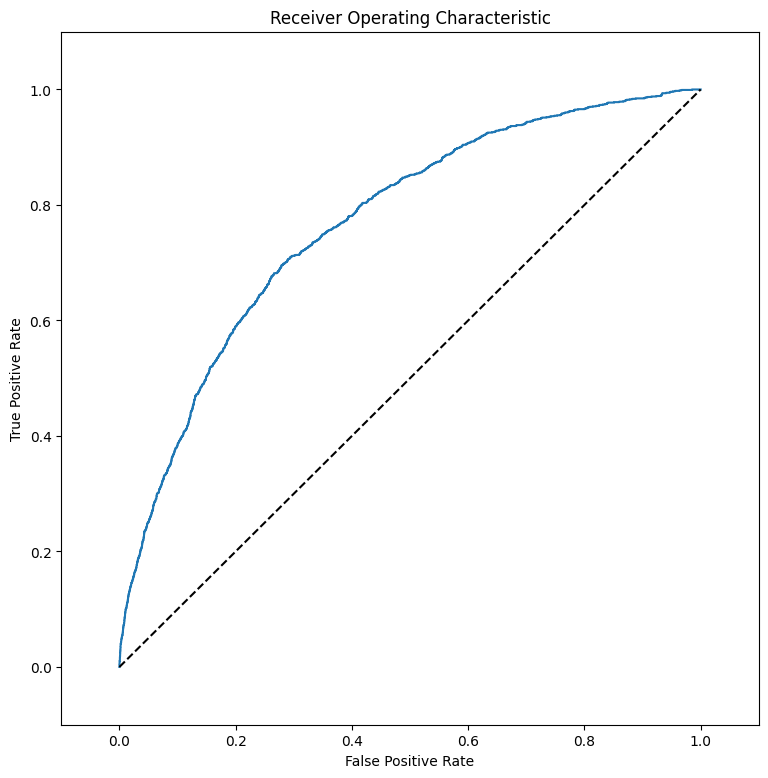

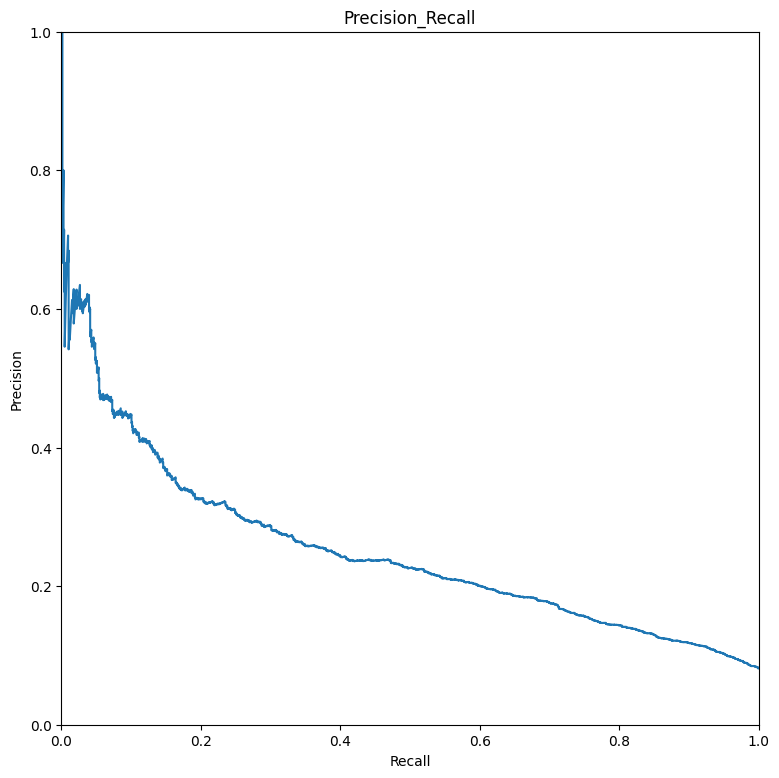

Processing application_train and application_test tables
Preprocessing final table and label encoding categorical features...
Applying LightGBM algorithm...
Training LightGBM model...
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s finished
Max cross-validation AUC: 0.7570325167353622
[LightGBM] [Info] Number of positive: 2286, number of negative: 26214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9522
[LightGBM] [Info] Number of data points in the train set: 28500, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080211 -

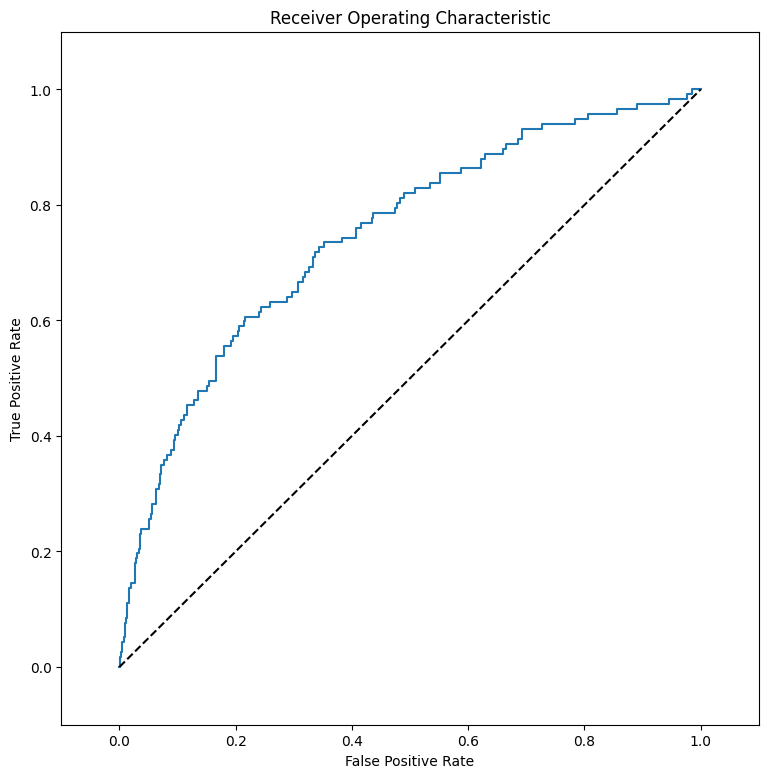

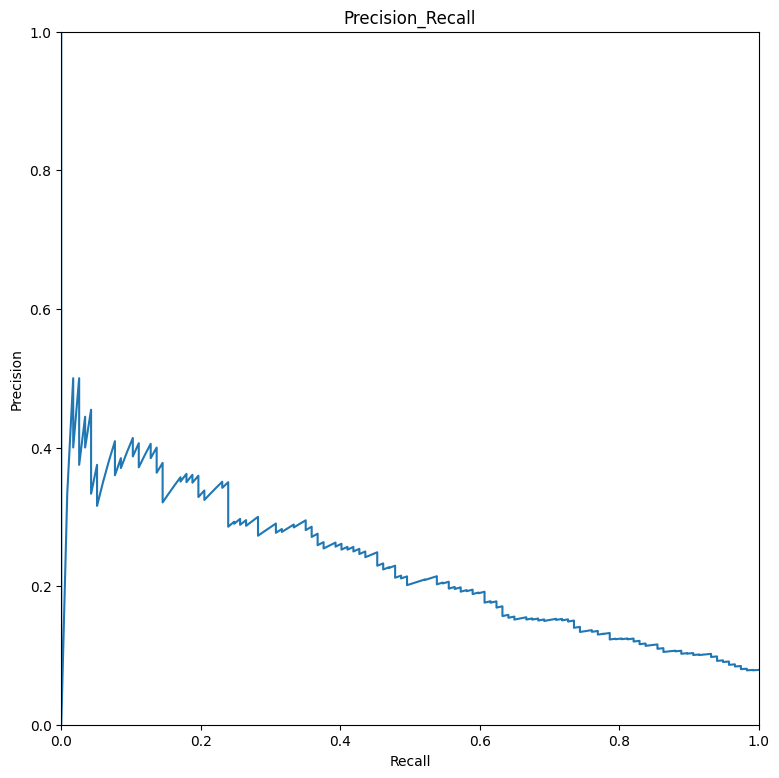

In [34]:
''' -------------------------------Main---------------------------
The main calls all funcitons sequentillay, merge the tables, train lightGBM, and plot the classification metrics.

LGBM performance is compared in two following considitons: 
    1) training data with concatenated CNN features 
    2) training data without CNN features.
    
'''
# nrows: number of rows considered in train data for the model due to the computational power limitation.
nrows = 30000

# 1) Model performance with concatenating CNN features
train, test = train_application()
# Extract new features using CNN
train, test = bureau_CNN_features(train, test, nrows)
print(train.shape)
# Preprocesing including label encoding of categorical varibles for LightGBM 
train, test = preprocessing(train, test)
# Training LightGBM
nfolds = 5 # number of folds for cross-validation (default is 5)
test_size = 0.05 # ratio of test to train dataset 
pred_class, pred, y_test = lightGBM(train,test, nfolds, test_size)
# Evalutate ROC_AUC, Precision, Recall, F1-Score, Kohen-Cappa metrics
calculate_metrics(pred_class, pred, y_test)
# Plot ROC curve
plot_ROC(y_test, pred)
# Plot Precision/R curve
plot_precision_recall(y_test, pred)

# 2) Model performance without CNN features
train, test = train_application()
train= train[:nrows]
# Preprocesing including label encoding of categorical varibles for LightGBM 
train, test = preprocessing(train, test)
train = train[:nrows]
# Training LightGBM
nfolds = 3
test_size = 0.05
pred_class, pred, y_test = lightGBM(train,test, nfolds, test_size)
# Evalutate ROC_AUC, Precision, Recall, F1-Score, Kohen-Cappa metrics
calculate_metrics(pred_class, pred, y_test)
# Plot ROC curve
plot_ROC(y_test, pred)
# Plot Precision/R curve
plot_precision_recall(y_test, pred)